'''
import seaborn as sns

data set describpition display after the data cleaning section

1. price

plt.figure(figsize = (10, 8))
sns.distplot(ds["log_price"])
plt.title('Price distribution')
plt.show()

2. Propterty Type

sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'property_type',data = ds,order = ds['property_type'].value_counts().index,palette = "viridis")
plt.ylabel('Property type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

3. Room Type

sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
sns.countplot(y = 'room_type',data = ds,order = ds['room_type'].value_counts().index,palette = "viridis")
plt.ylabel('Room type',fontsize = 20, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()

'''


In [1]:
# Import all the necessary libraries 
# base modules
import os
import sys
import copy
import logging
from collections import OrderedDict

# for manipulating data
import numpy as np
import pandas as pd
import math
import dill

# for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
# Import and read the dataset
ds= pd.read_csv('D:/input/airbnb-price-prediction/train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/input/airbnb-price-prediction/train.csv'

# Data infomation

In [ ]:
# Take a glance at the dataset
ds.head()

In [ ]:
# Check the types of each column and count its non-null values
ds.info()


In [5]:
# Prinintg all unique values of all non-numerical columns to check if they are worthy to be numericalized. 
# For example, "description" and "url" contain too many variables, there are identical values.
for column in ds.columns:
    if (ds[column].dtype) == 'object' and column != 'zipcode':  
        print(column,"\n")
        print(ds[column].unique())
        print("\n------------------------------\n")

property_type 

['Apartment' 'House' 'Condominium' 'Loft' 'Townhouse' 'Hostel'
 'Guest suite' 'Bed & Breakfast' 'Bungalow' 'Guesthouse' 'Dorm' 'Other'
 'Camper/RV' 'Villa' 'Boutique hotel' 'Timeshare' 'In-law' 'Boat'
 'Serviced apartment' 'Castle' 'Cabin' 'Treehouse' 'Tipi' 'Vacation home'
 'Tent' 'Hut' 'Casa particular' 'Chalet' 'Yurt' 'Earth House'
 'Parking Space' 'Train' 'Cave' 'Lighthouse' 'Island']

------------------------------

room_type 

['Entire home/apt' 'Private room' 'Shared room']

------------------------------

amenities 

['{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'
 '{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'
 '{TV,"Cable TV","Wireless Internet","Air conditioning",Kitchen,Breakfast,"

In [6]:
# Amenities contains serveral common features, 
amenities_col = []
amenities_map = {}
for s in ds.amenities:
    s = s.replace('{','')
    s = s.replace('}','')
    s = s.replace('"','')
    s = s.split(',')
    amenities_col.append(max(len(s)-1,0))
    for k in s:
        if amenities_map.get(k) != None:
            amenities_map[k] +=1 
        else:
            amenities_map[k] = 1

<BarContainer object of 20 artists>

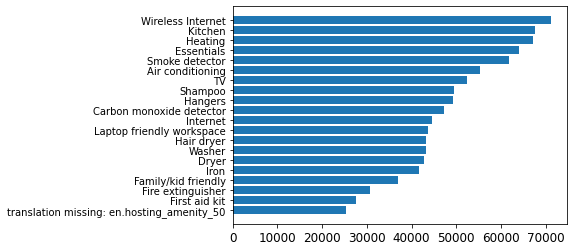

In [7]:
sorted_values = sorted(amenities_map.values()) # Sort the values
sorted_dict = {}
for i in sorted_values:
    for k in amenities_map.keys():
        if amenities_map[k] == i:
            sorted_dict[k] = amenities_map[k]
            break

keys = sorted_dict.keys()

values = sorted_dict.values()

plt.xticks(fontsize=12)
n = 20
plt.barh(list(keys)[-n:], list(values)[-n:], align='center')

In [8]:
ds['amenities_count'] = pd.Series(amenities_col)

In [9]:
import seaborn as sns

<AxesSubplot: >

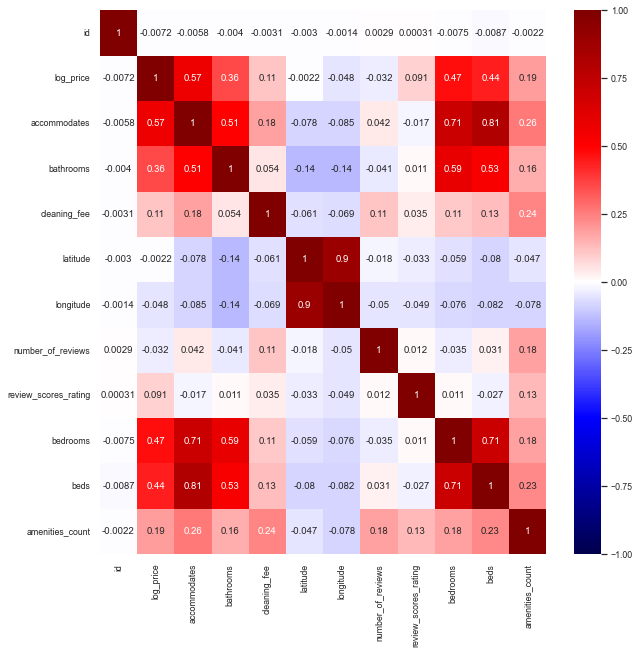

In [10]:
sns.set(font_scale=0.8)
plt.figure(figsize=(10,10))
sns.heatmap(ds.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

In [11]:
ds.drop(['id','amenities','description','latitude','longitude','thumbnail_url','zipcode'],axis=1,inplace=True)

In [12]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   accommodates            74111 non-null  int64  
 4   bathrooms               73911 non-null  float64
 5   bed_type                74111 non-null  object 
 6   cancellation_policy     74111 non-null  object 
 7   cleaning_fee            74111 non-null  bool   
 8   city                    74111 non-null  object 
 9   first_review            58247 non-null  object 
 10  host_has_profile_pic    73923 non-null  object 
 11  host_identity_verified  73923 non-null  object 
 12  host_response_rate      55812 non-null  object 
 13  host_since              73923 non-null  object 
 14  instant_bookable        74111 non-null

In [13]:
'''The describe() method is used for calculating some statistical data 
like percentile, mean and std of the numerical values of the Series or DataFrame. 
It analyzes both numeric and object series and also the DataFrame column sets of mixed data types.
'''
ds.describe()

,log_price,accommodates,bathrooms,number_of_reviews,review_scores_rating,bedrooms,beds,amenities_count
count,74111.000000,74111.000000,73911.000000,74111.000000,57389.000000,74020.000000,73980.000000,74111.000000
mean,4.782069,3.155146,1.235263,20.900568,94.067365,1.265793,1.710868,16.602407
std,0.717394,2.153589,0.582044,37.828641,7.836556,0.852143,1.254142,6.936947
min,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000
25%,4.317488,2.000000,1.000000,1.000000,92.000000,1.000000,1.000000,12.000000
50%,4.709530,2.000000,1.000000,6.000000,96.000000,1.000000,1.000000,16.000000
75%,5.220356,4.000000,1.000000,23.000000,100.000000,1.000000,2.000000,21.000000
max,7.600402,16.000000,8.000000,605.000000,100.000000,10.000000,18.000000,85.000000


## Data Pre-processing

In [14]:
ds.isna().sum()

log_price                     0
property_type                 0
room_type                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
bedrooms                     91
beds                        131
amenities_count               0
dtype: int64

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [16]:
display_all(ds.isnull().describe().T)

,count,unique,top,freq
log_price,74111,1,False,74111
property_type,74111,1,False,74111
room_type,74111,1,False,74111
accommodates,74111,1,False,74111
bathrooms,74111,2,False,73911
bed_type,74111,1,False,74111
cancellation_policy,74111,1,False,74111
cleaning_fee,74111,1,False,74111
city,74111,1,False,74111
first_review,74111,2,False,58247


In [17]:
from emlyon.utils import *

In [18]:
df, y, nas = proc_df(ds, 'log_price')

In [19]:
print(df.shape)
df.head()

(74111, 26)


,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,...,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,amenities_count,bathrooms_na,review_scores_rating_na,bedrooms_na,beds_na
0,1,1,3,1.0,5,3,True,5,2080,2,...,78,2,100.0,1.0,1.0,8,False,False,False,False
1,1,1,7,1.0,5,3,True,5,2493,2,...,253,6,93.0,3.0,3.0,14,False,False,False,False
2,1,1,5,1.0,5,2,True,5,2396,2,...,248,10,92.0,1.0,3.0,18,False,False,False,False
3,18,1,4,1.0,5,1,True,6,0,2,...,326,0,96.0,2.0,2.0,14,False,True,False,False
4,1,1,2,1.0,5,2,True,3,1677,2,...,120,4,40.0,0.0,1.0,11,False,False,False,False


In [20]:
df.isna().sum()

property_type              0
room_type                  0
accommodates               0
bathrooms                  0
bed_type                   0
cancellation_policy        0
cleaning_fee               0
city                       0
first_review               0
host_has_profile_pic       0
host_identity_verified     0
host_response_rate         0
host_since                 0
instant_bookable           0
last_review                0
name                       0
neighbourhood              0
number_of_reviews          0
review_scores_rating       0
bedrooms                   0
beds                       0
amenities_count            0
bathrooms_na               0
review_scores_rating_na    0
bedrooms_na                0
beds_na                    0
dtype: int64

# R2 Score of whole dataset

In [21]:
Model_LR_WD = LinearRegression()
%time Model_LR_WD.fit(df, y)
print('R^2 on whole dataset: {:.4f}'.format(Model_LR_WD.score(df,y)))

CPU times: total: 93.8 ms
Wall time: 151 ms
R^2 on whole dataset: 0.5496


In [22]:
Model_RS_WD = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)
#n_jobs =-1 meaning use as many as possible

%time Model_RS_WD.fit(df, y)
print('R^2 on whole dataset: {:.4f}'.format(Model_RS_WD.score(df,y)))

CPU times: total: 12.3 s
Wall time: 2.17 s
R^2 on whole dataset: 0.9323


#  Data Split

In [23]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [24]:
n_total = len(df)
n_valid = 24111  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
print('number of subsampled training points : {}'.format(n_small))

full number of data points : 74111
number of validation data points : 24111
number of training data points : 50000
number of subsampled training points : 20000


In [25]:
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 26), y = (20000,)
Number of full training data points: X = (50000, 26), y = (50000,)
Number of validation data points: X = (24111, 26), y = (24111,)


In [26]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [27]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

# Modeling with different algorithms

###  Linear Regression

In [28]:
Model_LR_S = LinearRegression()
%time Model_LR_S.fit(X_small, y_small)
print_score(Model_LR_S, X_small, y_small, X_valid, y_valid)

CPU times: total: 15.6 ms
Wall time: 37.7 ms
RMSE on train set: 0.4805
RMSE on valid set: 0.4850
R^2 on train set: 0.5503
R^2 on valid set: 0.5435


In [29]:
Model_LR_T = LinearRegression()

%time Model_LR_T.fit(X_train, y_train)
print_score(Model_LR_T, X_train, y_train, X_valid, y_valid)

CPU times: total: 93.8 ms
Wall time: 95 ms
RMSE on train set: 0.4800
RMSE on valid set: 0.4847
R^2 on train set: 0.5522
R^2 on valid set: 0.5440


###  Random Forest Basic Model

In [30]:
# model on small training data
Model_RF_S = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time Model_RF_S.fit(X_small, y_small)
print_score(Model_RF_S, X_small, y_small, X_valid, y_valid)

CPU times: total: 2.5 s
Wall time: 467 ms
RMSE on train set: 0.1944
RMSE on valid set: 0.4682
R^2 on train set: 0.9264
R^2 on valid set: 0.5745


In [31]:
# model on full training data
Model_RF_T = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time Model_RF_T.fit(X_train, y_train)
print_score(Model_RF_T, X_train, y_train, X_valid, y_valid)

CPU times: total: 7.52 s
Wall time: 1.35 s
RMSE on train set: 0.1876
RMSE on valid set: 0.4510
R^2 on train set: 0.9315
R^2 on valid set: 0.6052


###  Decision Tree Regressor

In [32]:
Model_DT_S_1 = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42,  
)

%time Model_DT_S_1.fit(X_small, y_small)
print_score(Model_DT_S_1, X_small, y_small, X_valid, y_valid)

CPU times: total: 0 ns
Wall time: 57.2 ms
RMSE on train set: 0.5028
RMSE on valid set: 0.5082
R^2 on train set: 0.5077
R^2 on valid set: 0.4986


C:\Users\XH\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[Text(0.5, 0.875, 'X[1] <= 1.5\nsquared_error = 0.513\nsamples = 20000\nvalue = 4.782'),
 Text(0.25, 0.625, 'X[3] <= 1.25\nsquared_error = 0.366\nsamples = 11141\nvalue = 5.168'),
 Text(0.125, 0.375, 'X[19] <= 1.5\nsquared_error = 0.245\nsamples = 8345\nvalue = 5.002'),
 Text(0.0625, 0.125, 'squared_error = 0.22\nsamples = 6405\nvalue = 4.932'),
 Text(0.1875, 0.125, 'squared_error = 0.257\nsamples = 1940\nvalue = 5.233'),
 Text(0.375, 0.375, 'X[3] <= 2.75\nsquared_error = 0.399\nsamples = 2796\nvalue = 5.664'),
 Text(0.3125, 0.125, 'squared_error = 0.333\nsamples = 2385\nvalue = 5.564'),
 Text(0.4375, 0.125, 'squared_error = 0.385\nsamples = 411\nvalue = 6.247'),
 Text(0.75, 0.625, 'X[7] <= 5.5\nsquared_error = 0.276\nsamples = 8859\nvalue = 4.297'),
 Text(0.625, 0.375, 'X[1] <= 2.5\nsquared_error = 0.26\nsamples = 8116\nvalue = 4.259'),
 Text(0.5625, 0.125, 'squared_error = 0.234\nsamples = 7557\nvalue = 4.289'),
 Text(0.6875, 0.125, 'squared_error = 0.436\nsamples = 559\nvalue = 3.85

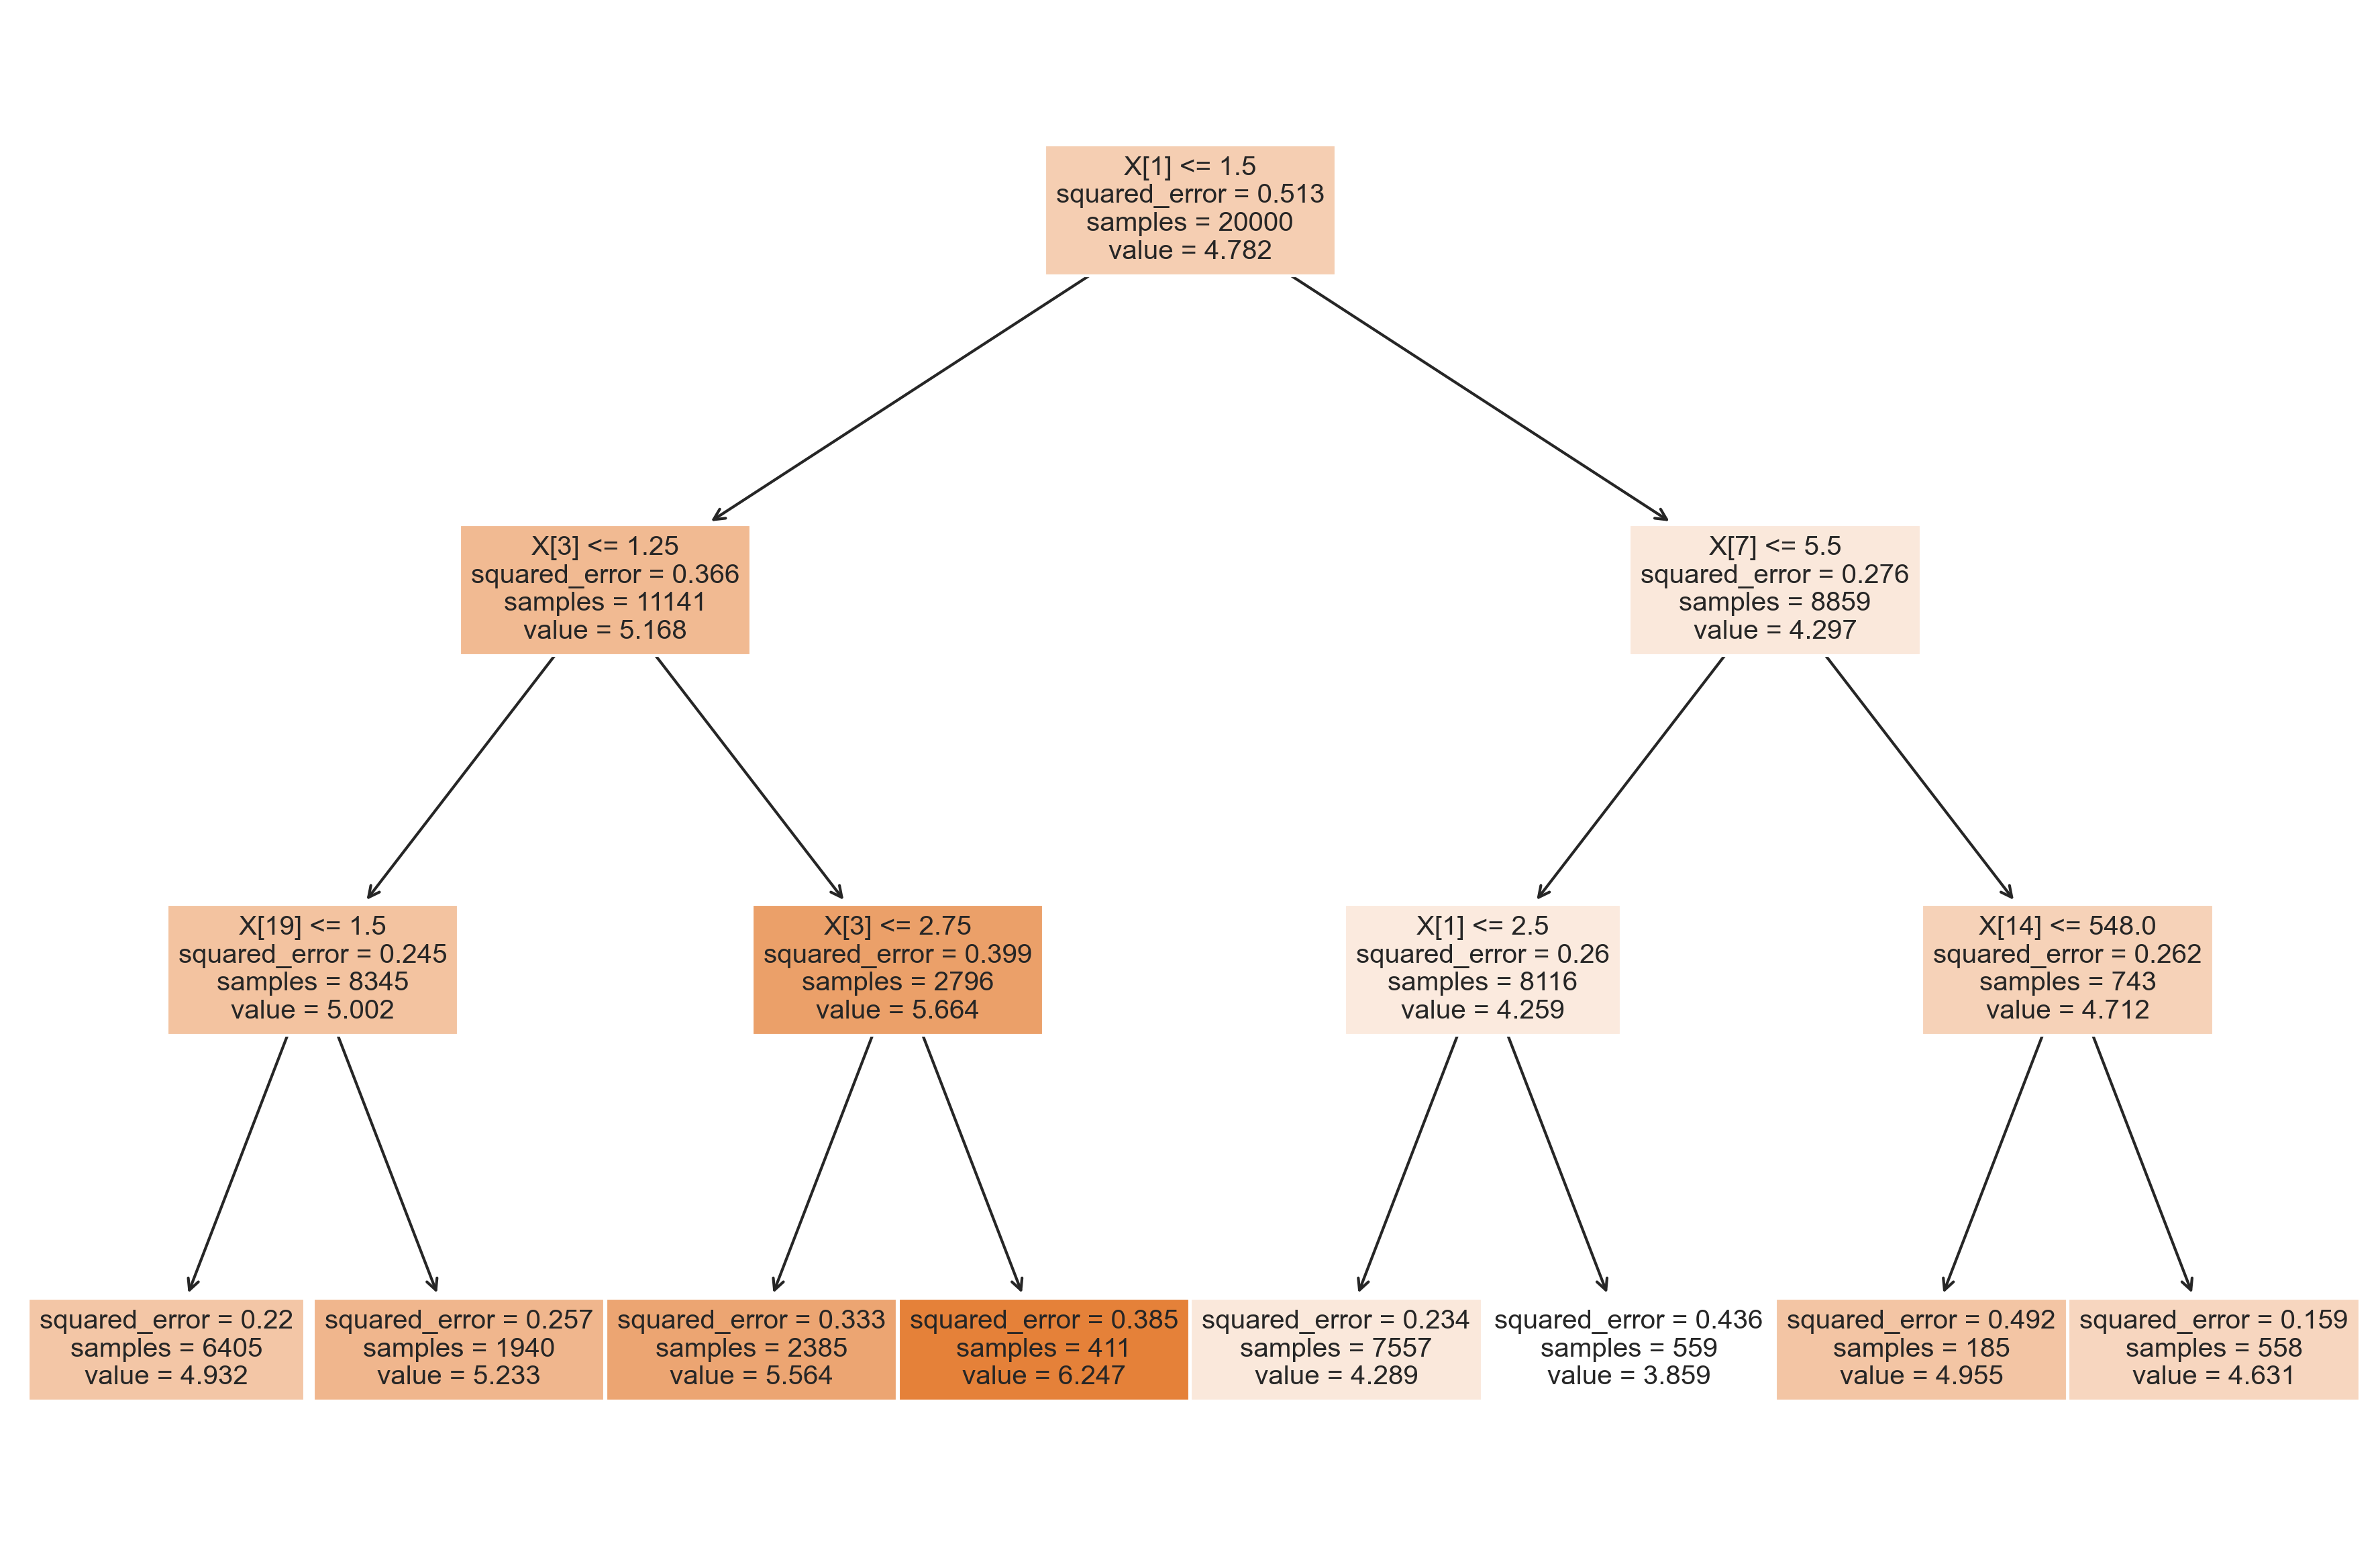

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi = 300)
plot_tree(Model_DT_S_1, filled = True)

In [34]:
Model_DT_S_2 = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 25, # changed max_depth into 25
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0001, # changed impurity into 0.0001
    ccp_alpha = 0.0,
    random_state = 42,
)

%time Model_DT_S_2.fit(X_small, y_small)
print_score(Model_DT_S_2, X_small, y_small, X_valid, y_valid)

CPU times: total: 109 ms
Wall time: 136 ms
RMSE on train set: 0.4129
RMSE on valid set: 0.4887
R^2 on train set: 0.6680
R^2 on valid set: 0.5364


C:\Users\XH\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [35]:
Model_DT_S_3 = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 30, # changed max_depth into 25
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.00001, # changed impurity into 0.0001
    ccp_alpha = 0.0,
    random_state = 42,
)

%time Model_DT_S_3.fit(X_small, y_small)
print_score(Model_DT_S_3, X_small, y_small, X_valid, y_valid)

C:\Users\XH\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


CPU times: total: 188 ms
Wall time: 219 ms
RMSE on train set: 0.1618
RMSE on valid set: 0.6136
R^2 on train set: 0.9490
R^2 on valid set: 0.2691


In [36]:

%time Model_DT_S_2.fit(X_train, y_train)
print_score(Model_DT_S_2, X_train, y_train, X_valid, y_valid)

C:\Users\XH\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


CPU times: total: 297 ms
Wall time: 322 ms
RMSE on train set: 0.4434
RMSE on valid set: 0.4642
R^2 on train set: 0.6178
R^2 on valid set: 0.5816


### Random Forest Regressor 

In [41]:
Model_RF_OOB_T  = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 50, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 7.67 s
Wall time: 1.27 s
RMSE on train set: 0.1727
RMSE on valid set: 0.4506
R^2 on train set: 0.9419
R^2 on valid set: 0.6058
R^2 on oob set: 0.5864


In [ ]:
model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 50, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

### Out-of-bag (OOB) score

In [ ]:
Model_RF_OOB_S = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time Model_RF_OOB_S.fit(X_small, y_small)
print_score(Model_RF_OOB_S, X_small, y_small, X_valid, y_valid)

In [ ]:
Model_RF_OOB_T = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time Model_RF_OOB_T .fit(X_train, y_train)
print_score(Model_RF_OOB_T , X_train, y_train, X_valid, y_valid)

### Data subsampling

In [ ]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

In [ ]:
model = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

###  Parameter tests

30 trees
R2 Score:  0.9419114289130274
 
50 trees
R2 Score:  0.9450749887956889
 
100 trees
R2 Score:  0.9472600585851142
 
200 trees
R2 Score:  0.948330371970163
 
500 trees
R2 Score:  0.9489126941864416
 
1000 trees
R2 Score:  0.9491860556384325
 
2000 trees
R2 Score:  0.9492398001182633
 


<AxesSubplot: >

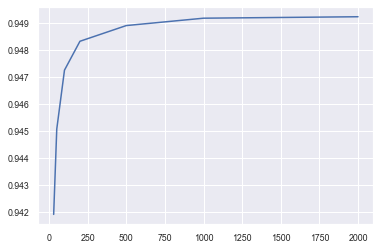

In [46]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_small, y_small)
    print(trees, 'trees')
    R2 = model.score(X_small, y_small)
    print('R2 Score: ', R2)
    results.append(R2)
    print (" ")
    
pd.Series(results, n_estimator_options).plot()

C:\Users\XH\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


auto option
R2 Score:  0.9489126941864416
 
None option
R2 Score:  0.9489126941864416
 
sqrt option
R2 Score:  0.9488964047574965
 
log2 option
R2 Score:  0.9486394492975373
 
0.9 option
R2 Score:  0.9491448705974432
 
1 option
R2 Score:  0.9441795541651128
 


<AxesSubplot: >

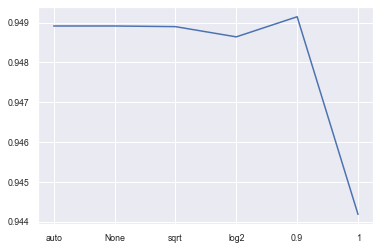

In [63]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 1]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=30, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_small, y_small)
    print(max_features, "option")
    R2 = model.score(X_small, y_small)
    print('R2 Score: ', R2)
    results.append(R2)
    print (" ")
    
pd.Series(results, max_features_options).plot()

1 min samples
R2 Score:  0.949475359895314
 
2 min samples
R2 Score:  0.9184490316096665
 
3 min samples
R2 Score:  0.8833519933093288
 
4 min samples
R2 Score:  0.8527432033456257
 
5 min samples
R2 Score:  0.8272614036353947
 
6 min samples
R2 Score:  0.8066370961922382
 
7 min samples
R2 Score:  0.7893176954368214
 
8 min samples
R2 Score:  0.7746806637944113
 
9 min samples
R2 Score:  0.7621059054134932
 
10 min samples
R2 Score:  0.7515290829373951
 


<AxesSubplot: >

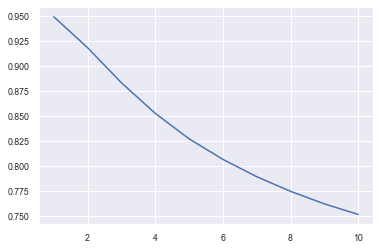

In [64]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=0.9, min_samples_leaf=min_samples)
    model.fit(X_small, y_small)
    print(min_samples, "min samples")
    R2 = model.score(X_small, y_small)
    print('R2 Score: ', R2)
    results.append(R2)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

10 max_depth
R2 Score:  0.7110566607572606
 
20 max_depth
R2 Score:  0.9169926145973517
 
30 max_depth
R2 Score:  0.9416859991812607
 
40 max_depth
R2 Score:  0.9426457203154377
 
50 max_depth
R2 Score:  0.9424210306950598
 


<AxesSubplot: >

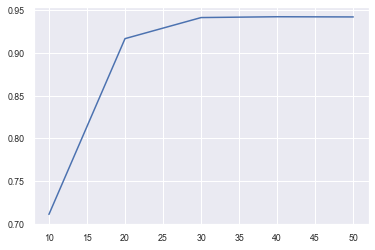

In [67]:
results = []
max_depth_options = [10,20,30,40,50]

for max_depth in max_depth_options:
    model = RandomForestRegressor(n_estimators=30, oob_score=True, n_jobs=-1, random_state=42, max_features=0.9, min_samples_leaf=1,max_depth=max_depth)
    model.fit(X_small, y_small)
    print(max_depth, "max_depth")
    R2 = model.score(X_small, y_small)
    print('R2 Score: ', R2)
    results.append(R2)
    print (" ")
    
pd.Series(results, max_depth_options).plot()

In [70]:
Parameter_test_Model  = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 1000, 
    criterion = 'squared_error', 
    max_depth = 35, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = 0.9, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = True, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 6.62 s
Wall time: 1.13 s
RMSE on train set: 0.1719
RMSE on valid set: 0.4488
R^2 on train set: 0.9424
R^2 on valid set: 0.6091
R^2 on oob set: 0.5902


## Hyperparameter tuning for final model selection

In [56]:
param_grid = [
    {'n_estimators': [10, 50],
     'max_depth': [10, 20, None],
     'min_samples_split': [2, 10],
     'max_features': [0.4, 0.75, 1.],
     'max_samples': [0.4, 0.75, 1.],
    },
]

model = RandomForestRegressor(
    random_state = 42,
    bootstrap = True,
)

In [57]:
tuned_model = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method
    n_jobs = -1, 
    refit = True, # keep a fitted version of the overall best model
    cv = 5, 
    return_train_score = True,
    verbose = 2,
)

In [58]:
tuned_model.fit(X_small, y_small)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [10, 20, None],
                          'max_features': [0.4, 0.75, 1.0],
                          'max_samples': [0.4, 0.75, 1.0],
                          'min_samples_split': [2, 10],
                          'n_estimators': [10, 50]}],
             return_train_score=True, verbose=2)

In [59]:
best_model = tuned_model.best_estimator_
best_model

RandomForestRegressor(max_features=0.75, max_samples=0.75, min_samples_split=10,
                      n_estimators=50, random_state=42)

In [65]:
print_score(best_model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.2823
RMSE on valid set: 0.4443
R^2 on train set: 0.8448
R^2 on valid set: 0.6168


In [72]:
cv = KFold(n_splits = 8, shuffle = True, random_state = 42)

scores = cross_val_score(best_model, X_small, y_small, cv = cv, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.61066555 0.63289573 0.6239215  0.61107919 0.6084458  0.62400663
 0.63087087 0.62279959]
r2 is 0.621 with a standard deviation of 0.009


# Classification

In [ ]:
'''tree_classifier = DecisionTreeClassifier(
    class_weight = None, # specific to classifiers
    criterion = 'gini',  # specific to classifiers
    splitter = 'best', 
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = None, 
)'''

In [ ]:
'''%time tree_classifier.fit(X_small, y_cat_2_small)

print(tree_classifier.score(X_small, y_cat_2_small))
print(tree_classifier.score(X_valid, y_cat_2_valid))'''